In [1]:
import os,sys

elections = ['2004','2007','2010','2013','2016','2019','2022']
files = ['pollingplaces', 'primaries', 'tpptcp']

In [2]:
import pandas as pd
import numpy as np

In [6]:
def makeid(row):
    pollingid = str(row["PollingPlaceID"])
    partyid = row["PartyAb"]

    if type(partyid) != str:
        if np.isnan(partyid):
            partyid = row["Surname"].upper()
    elif partyid.upper() == "IND":
        partyid = row["Surname"].upper()

    return str(row["PollingPlaceID"])+str(partyid)

dfs = []
for electionyear in elections:
    for file in os.listdir(f"./data/{electionyear}/{files[1]}"):
        file = os.path.join(f"./data/{electionyear}/{files[1]}",file)
        if 'prdelms' in file:
            ppid_locations = pd.read_csv(file)
            continue
        boothresults = pd.read_csv(file,header=1)
        try:
            boothresults['id'] = boothresults.apply(makeid, axis=1)
        except KeyError as e:
            print(file)
            raise e     
        boothresults['year'] = electionyear
        boothresults['uniqueid'] = boothresults.apply(lambda row: str(row["id"])+str(row["year"]), axis=1)

        boothresults.set_index('uniqueid', inplace=True)
        dfs.append(boothresults)



In [7]:
df = pd.concat(dfs)
df = df[df['StateAb']=='NSW']
# df = df[df['year']==2022]

df.head()

,StateAb,DivisionID,DivisionNm,PollingPlaceID,PollingPlace,CandidateID,Surname,GivenNm,BallotPosition,SittingMemberFl,PartyAb,PartyNm,OrdinaryVotes,Swing,id,year,Elected,HistoricElected
uniqueid,,,,,,,,,,,,,,,,,,
1HAN2004,NSW,103,Banks,1,Beverly Hills North,15349,STAVRINOS,Harry,1,NaN,HAN,Pauline Hanson's One Nation (NSW Division),49,-2.52,1HAN,2004,NaN,NaN
1GRN2004,NSW,103,Banks,1,Beverly Hills North,14170,MAKIN,Stephen,2,NaN,GRN,The Greens,107,1.58,1GRN,2004,NaN,NaN
1LP2004,NSW,103,Banks,1,Beverly Hills North,14709,GRAY,Roger,3,NaN,LP,Liberal,990,6.33,1LP,2004,NaN,NaN
1FFP2004,NSW,103,Banks,1,Beverly Hills North,15410,BRISCOE-HOUGH,Greg,4,NaN,FFP,Family First,20,0.79,1FFP,2004,NaN,NaN
1DEM2004,NSW,103,Banks,1,Beverly Hills North,15556,CLYBURN,Mark,5,NaN,DEM,Australian Democrats,15,-1.99,1DEM,2004,NaN,NaN


In [8]:
pivot_df = df.pivot(index="id",columns='year', values='OrdinaryVotes')
covmat = pivot_df.dropna(axis=0).T.corr()

In [9]:
import matplotlib.pyplot as plt

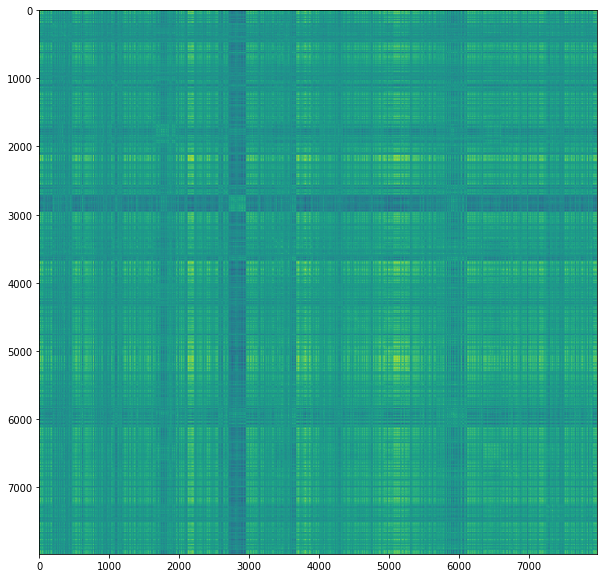

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(covmat.values, cmap='viridis', aspect='auto')
plt.show()

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(46)
kmeans.fit_predict(covmat)

In [ ]:
cluster_labels = kmeans.fit_predict(covmat)

# Reorder the correlation matrix based on the cluster labels
sorted_indices = np.argsort(cluster_labels)
sorted_correlation_matrix = covmat.iloc[sorted_indices][covmat.columns[sorted_indices]]

plt.figure(figsize=(22,22),dpi=200)
plt.imshow(sorted_correlation_matrix, cmap='viridis', aspect='auto')
plt.grid(False)
plt.show()

In [ ]:
pivot_df.dropna(axis=0).index[np.where(cluster_labels==1)]

In [ ]:
communities_df = []
for label in np.unique(cluster_labels):
    testdf = df[df['id'].isin(pivot_df.dropna(axis=0).index[np.where(cluster_labels==label)])]
    partyvotes = testdf.groupby(['PartyAb', 'year'])['OrdinaryVotes'].sum().reset_index().sort_values(by='year')
    partyvotes['normalized_score'] = partyvotes['OrdinaryVotes'] / partyvotes.groupby('year')['OrdinaryVotes'].transform('sum')
    communities_df.append(partyvotes.pivot_table(index='PartyAb', columns='year', values='normalized_score', fill_value=0))
    

In [ ]:
winners = {}
for community in communities_df:
    winner = community["2022"].idxmax()
    if winner in winners.keys():
        winners[winner]+=1
    else:
        winners[winner]=1

In [ ]:
winners

In [ ]:
import geopandas as gpd
import networkx as nx

In [ ]:
electoralboundares = gpd.read_file("nsw-esri-06042016/NSW_electoral_boundaries_25-02-2016.shp")

In [ ]:
electoralboundares.columns

In [ ]:
sa1s = gpd.read_file("nsw-esri-06042016/NSW_SA1s_25-02-2016.shp")

In [ ]:
sa1s.columns

In [ ]:
sa1s.explore()

In [ ]:
unfliteredsa1geodata = gpd.read_file("SA1_2021_AUST_SHP_GDA2020/SA1_2021_AUST_GDA2020.shp")
unfliteredsa1geodata.head()

In [ ]:
unfliteredsa1geodata[unfliteredsa1geodata['SA2_NAME21'].str.contains('Sydney')]

In [ ]:
sa1geodata=unfliteredsa1geodata[~unfliteredsa1geodata["geometry"].isnull()]
sa1geodata=sa1geodata[sa1geodata['STE_NAME21']=='New South Wales']
sa1geodata=sa1geodata[["SA1_CODE21","AREASQKM21","geometry"]]
sa1geodata['centroids']=sa1geodata['geometry'].to_crs('+proj=cea').centroid.to_crs(sa1geodata.crs)
print(sa1geodata.shape)
sa1geodata.head()

In [ ]:
sa1geodata['neighbours']= sa1geodata.apply(lambda row: row.geometry.touches(sa1geodata.geometry).astype(int).to_numpy(),axis=1)

In [ ]:
A = np.asarray(sa1geodata['neighbours'].to_list())

In [ ]:
G = nx.from_numpy_array(A)

# Australian Electoral Distributions
After the previous election in on the 21st May 2022, it was announced that there would be a redistribution of the electoral boundaries. This happens whenever there a population shifts across the states. Under the constitution the number of seats that each state is entitled is determined a formula dependent on the size of the senate and on the relative populations of each the states. As a result of Western Australia's (WA) population growth it was determined that the number of seats should increase from 15 to 16, while Victoria and NSW were both set to lose seats.

This triggers a redrawing of the electoral boundaries in each of the states. This process is called a redistribution and follows these steps:

1. An independent committee is established by the Australian Electoral Commission (AEC) to oversee the redistribution.
2. Political parties, independent members, members of the public and other stakeholders make written suggestions to the committee.
3. These suggestions are then opened for comment and further submissions.
4. The committee takes into account the suggestions as well as a set of principles and conventions and for drawing boundaries to make a proposed redistribution map.
5. Objections may then be filed with the committee regarding the proposed redistribution.
6. Again comments on the objections may be lodged.
7. Final boundaries taking into account the objections are announced.

This process is designed to ensure independence and transparency with respect to the drawing of boundaries. In practice, the most important submissions made to the AEC are the ones made by the major parties. That is, the Labor Party (ALP) and the Liberal Party (LP). Although other promiment submissions are the National Party (NP) and the Greens' submission (GP). Having said this, the committee does not treat these submissions as ambit claims an make a determination on which claim to accept. Instead, they are merely suggestions and commentary and the committee is responsible for drafting boundaries with respect to the following principles:
1. The number of electorates as determined by the constitution and the electoral act.
2. Each electorate must be, as far as practicable, within $\pm 3.5 \% $ of the projected enrolment quota. This is the projected total number of electors in the state divided by the number of electorates.
3. The number of electors enrolled in each electorate must strictly be within $\pm 10 \%$ of the redistribution quota. This is a weaker requirement but must be enforced, whereas the above is preferable.
4. Each electorate must be drawn with respect to the following considerations:
    i. The community of interests within the seat, which may include economic, social and regional interests.
    ii. Communication and travel within the electorate.
    iii. The physical features and area of the proposed electorate.
    iv. The existing boundaries of the electorate insofar as the seat already exists, will continue to exist and subject to all the above requirements.

Most of the requirements can be interpreted more simply. The electorates should all be approximately equal in population (of eligble voters). The electorates where possible should be geographically contiguous and respect local geography. The electorates should be drawn so that local communities are well represented.

What is remarkable about these requirements is that none specify how the voteshare of political parties should be represented. That is there is no requirements that the distribution not be gerrymandered. There is no requirement that the redistribution committee give weight to the primary votes of the political parties in an attempt to ensure political representation. Instead, the boundaries are drawn with respect to ensuring social and economic representation.

This is a curious thing given comparisons to the states and other nations. Most of the Australian states territories, which use comparable voting systems, have similarly vague requirements. The exception is South Australia, which contains provisions to ensure boundaries respect the popular vote, which has come to be interpreted as the two-preferred-vote. The irony of this, is that they have had some of the worst performing electoral distributions with respect to representing the votes of their electors. By contrast, the United States explicitly draws boundaries with respect to the voteshare of the Democratic and Republican parties. The process of gerrymandering has been almost perfected to an artform, with Republican controlled states drawing boundaries that benefit them in elections and Democratic controlled states doing the same. The techniques in order to maximise the expected number of seats are complex and in depth. There are legal barriers such as the Voting Rights Act (VRA) which makes racially disproportionate boundaries illegal - however, boundaries drawn on partisan discrimination remains legal, at least federally. We will not discuss an exhaustive list here, but they include the process of cracking and stacking electorates. Suppose a Republican was in charge of drawing the maps of North Carolina. North Carolina is a marginal state that is competitive in most elections for either party and is usually closer to 50-50 in terms of voteshare. A Republican would attempt to "crack" existing marginal Democratic seats and fold the competitive areas into pro-Republican terrain to create a more Republican leaning seat. The remaining pro-Democratic votes from this seat is then "stacked" into an already safe Democratic seat. In practice, one can identify that a state's maps have been gerrymandered due to the unusually high amount of very safe seats and an abnormally low number of competitive seats. This process is undemocratic on its face, but I would like to draw your attention to some key points.

First, it leads to election outcomes that are not representative of the will of the people. In 2020, in the US House of Represenatives elections $50%$ voted for the Democrats and $49.4%$ voted voted for the Republicans. A narrow Democratic victory in the popular vote. The Republicans won $8$ seats and the Democrats won $5$. This result is common enough across the United States. Lopsided victories by one party that received more seats than it was reasonably due from its voteshare. These outcomes mask the will of the people. Electorates should represent communities, or else their members are no longer representatives.

Secondly, it creates pervous electoral incentives for members. If boundaries are drawn so that they are unusually safe then competition for the seat takes place in the primaries. In the US, each party conducts a primary (or occasionally a caucus) election in order to choose their candidate. In safe seats, internal party disputes become prominent. Members are elected who best represent the party, as opposed to the seat. This lends itself to extremism and a lack of political civility.

To some extent, some of these trends are occuring in Australia as well. Almost one third of Australians did not vote for a major party at the 2022 election. Many candidates ran on denying either the ALP or the Liberal National Coalition (L/NP) a majority. However, the distributions as well as the preference flows mostly to Labor, ensured that Labor won 77 seats out of the 151 in parliament, a majority of 2 - while the L/NP won just 58. The Greens campaign on denying Labor a majority, thereby forcing the ALP to work with the Greens in order to progress policy. The point is minority government. Similarly, many of the Teal independents support the concept of minority government. 

Federally, Labor won just under $33%$ of the vote on primaries and just over $52%$ of the two-party-preferred vote (TPP). They won $51%$ of the seats. The Coalition won $38%$ of the seats despite receiving just shy of $36%$ of the primary vote and $48%$ of the TPP. Meanwhile, in the NSW 2023 election, Labor received $37%$ of the primary vote and $54%$ of the two-party preferred. They won a minority $48%$ of the seats. The L/NP won $35%$ of the primary vote and $46%$ of the TPP and won $39%$ of the seats. Is this fair? Labor performed better federally with less votes than they did in NSW, while the Coalition performed worse on a TPP in NSW but performed about the same in terms of seats.

Perhaps it was just luck of the draw. After all, in 1998, the ALP won the TPP federally, but the Coalition, led by John Howard, retained a majority. When do we know that a set of maps is unfair?

Moreover, in a multi-party preferential democracy what does fair even mean?

In a representative electoral system, the Greens $12%$ of the vote entitles them to $12%$ of the seats. This is close to how the Australian senate functions, with some important distinctions. However, the lower house uses a preferential system designed to elect majoritarian governments. There a good reasons for representative parliaments but also for majoritarian governments also. The questions I will seek to define and answer all come down to one root question: **when shouldn't our preferential system elect a majority government**?

When is clear that the people want a government that is forced to negotiate in order to gain executive power? How do we draw boundaries to reflect this? Are Australia's current boundaries fair? What even are the communities of interest that the Redistribution Committees are supposed to reflect? How does the proportionate upper house affect these considerations? How do we design systems that reflect the current political reality of a two-party political system in long-term decline? Has the AEC done a good job of reflecting this long-term decline or has the preferential voting system papered over the cracks growing in our polity? Isn't that the point of preferential voting?


There are many questions that require being asked and answered. Democracy is not a stationary fixed element. In changes as the needs of the people changes. If it does not evolve, then it risks losing its legitimacy. Australian political debate has tried to avoid these questions, perhaps wisely. But they are fast approaching. This is an attempt to put a first draft of these questions and some answers to paper. It will require political, historical and philosophical considerations as well as mathematical and statistical ones.

After all, if our electoral boundaries are not fair, then neither are the results of our election.